# Setup

In [4]:
import os
import tempfile
import time
import numpy as np
from typing import Tuple
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

from torchgeo.datasets import NAIP, ChesapeakeDE
from torchgeo.datasets.utils import download_url, stack_samples
from torchgeo.samplers import RandomGeoSampler, GridGeoSampler, RandomBatchGeoSampler

# Data

In [5]:
data_root = tempfile.gettempdir()
naip_root = os.path.join(data_root, "naip_train")
naip_url = (
    "https://naipeuwest.blob.core.windows.net/naip/v002/de/2018/de_060cm_2018/38075/"
)
tiles = [
    "m_3807511_ne_18_060_20181104.tif",
    # "m_3807511_se_18_060_20181104.tif",
    # "m_3807512_nw_18_060_20180815.tif",
    # "m_3807512_sw_18_060_20180815.tif",
]
for tile in tiles:
    download_url(naip_url + tile, naip_root)

100%|██████████| 513332284/513332284 [03:11<00:00, 2680707.23it/s]


Next, we tell TorchGeo to automatically download the corresponding Chesapeake labels.

In [6]:
chesapeake_root = os.path.join(data_root, "chesapeake_train")

chesapeake = ChesapeakeDE(chesapeake_root, download=True)

100%|██████████| 287350495/287350495 [07:16<00:00, 657784.93it/s] 


OSError: [Errno 28] No space left on device

# Data exploration

In [7]:
cache = True

In [8]:
chesapeake = ChesapeakeDE(chesapeake_root, cache=cache)
naip = NAIP(naip_root, crs=chesapeake.crs, res=chesapeake.res, cache=cache)

# we create an IntersectionDataset so that we can automatically sample from both
# GeoDatasets simultaneously.
dataset = chesapeake & naip

#Unlike typical PyTorch Datasets, TorchGeo GeoDatasets are indexed using 
# lat/long/time bounding boxes. This requires us to use a custom GeoSampler 
# instead of the default sampler/batch_sampler that comes with PyTorch.
sampler = GridGeoSampler(dataset, size=1000, stride=500)

# we combine the dataset and the sampler into a dataloader
dataloader = DataLoader(
    dataset, batch_size=12, sampler=sampler, collate_fn=stack_samples
)

In [1]:
dataset.classes

NameError: name 'dataset' is not defined

In [17]:
sample = next(iter(dataloader))
image = sample["image"]
target = sample["mask"]
image.shape, target.shape

(torch.Size([12, 4, 1000, 1000]), torch.Size([12, 1, 1000, 1000]))

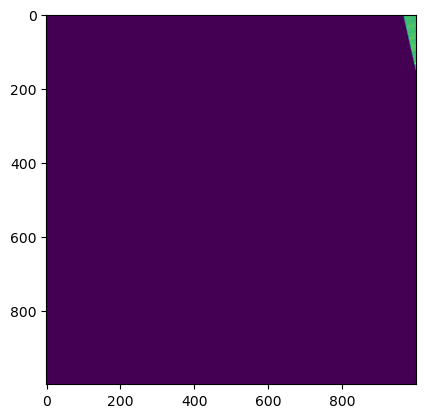

In [57]:
plt.imshow(image[1,3,:])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


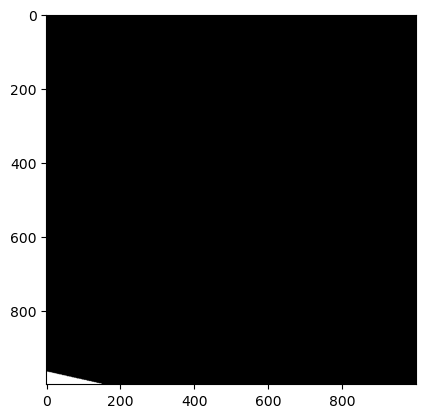

In [48]:
plt.imshow(image[1,0:3,:,:].T)

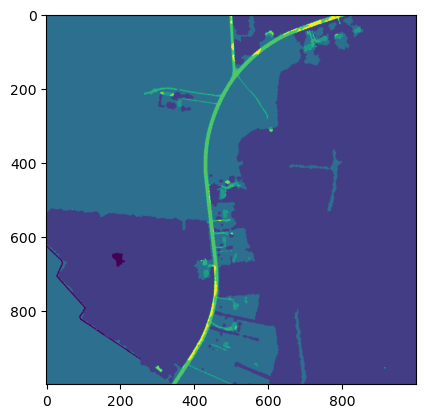

In [41]:
plt.imshow(target[4,0,:,:])